In [1]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/Colab Notebooks/SDC_P4/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# !pip install keras==2.2.4
!pip show keras  # 2.2.4 for P4

Name: Keras
Version: 2.2.4
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, h5py, scipy, pyyaml, numpy, keras-applications, keras-preprocessing
Required-by: 


In [0]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.misc

In [6]:
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Cropping2D


Using TensorFlow backend.


### Prepare data set

In [7]:
df2 = pd.read_csv(drive_path + 'data/driving_log.csv')
df = df2.tail(50)  # small sample size to check code
imgName = df[['center', 'left', 'right']].values
angle = df['steering'].values

# Split the data
X_trainfname, X_validfname, y_trainang, y_validang = train_test_split(imgName, angle, test_size=0.2, shuffle= True)
TrainSize = len(X_trainfname); print("Training Sample Size = ", TrainSize)
ValidSize = len(X_validfname); print("Validation Sample Size = ",ValidSize)

Training Sample Size =  40
Validation Sample Size =  10


### Data Generator

In [0]:
def aug_flip(images, angles):
    augflip_img = []
    augflip_ang = []
    for (img, ang) in zip(images, angles):
      augflip_img.append(img)
      augflip_ang.append(ang)
      augflip_img.append(cv2.flip(img, 1))
      augflip_ang.append(ang*(-1.0))        
    return np.array(augflip_img), np.array(augflip_ang)

In [0]:
def generator(X_trainfname, y_trainang, batch_size=32):
    num_samples = len(y_trainang)
    while 1: # Loop forever so the generator never terminates

        for offset in range(0, num_samples, batch_size):
            batch_imgName = X_trainfname[offset:offset+batch_size]
            batch_angle = y_trainang[offset:offset+batch_size]

            images = []
            angles = []
            for k in range(0,len(batch_angle)):
              for j in range(0,3):
                name = drive_path + 'data/' + batch_imgName[k][j]
                center_image = cv2.imread(name)
#                 center_image = ndimage.imread(current_path) # not seem to be working
                if center_image is None:
                  continue  #print(center_image)
                else: 
                  center_angle = float(batch_angle[k])

                  images.append(center_image)
                  angles.append(center_angle)
            # call pre-process - flipping
            augflip_img, augflip_ang = aug_flip(images, angles)
            
            yield shuffle(np.array(augflip_img), np.array(augflip_ang))
            
train_generator= generator(X_trainfname, y_trainang)
validation_generator= generator(X_validfname, y_validang)    

### Toy Model (to test simulator and video making)

In [0]:
# small size data for toy model input
X_toyfname = imgName[1:5,0]
y_toy = angle[1:5]
toy_images = []
toy_angles = []

for k in range(0,len(y_toy)):
        name = drive_path + 'data/' + X_toyfname[k]
        center_image = cv2.imread(name)
        center_angle = float(y_toy[k])
        toy_images.append(center_image)
        toy_angles.append(center_angle)

In [12]:
# toy model 
model = Sequential()
model.add(Flatten(input_shape=(160,320,3)))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
model.fit(np.array(toy_images), np.array(toy_angles), validation_split = 0.2, shuffle = True, epochs = 3)

model.save(drive_path + 'Toydmodel01.h5')







Train on 3 samples, validate on 1 samples
Epoch 1/3
3/3 [==============================] - 5s 2s/step - loss: 56677.4961 - val_loss: 362280576.0000
Epoch 2/3
3/3 [==============================] - 0s 6ms/step - loss: 363018368.0000 - val_loss: 23382116.0000
Epoch 3/3
3/3 [==============================] - 0s 4ms/step - loss: 23625586.0000 - val_loss: 78275888.0000


### Build Model

In [13]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=(160,320,3)))
model.add(Cropping2D(cropping = ((60,25),(0,0)))) # 60 pixels from the top and 25 pixels from the bottom. ((top_crop, bottom_crop), (left_crop, right_crop))
model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 35, 64)         27712     
___________________________

In [14]:
batch_size=32
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, 
            steps_per_epoch = TrainSize, 
            validation_data = validation_generator, 
            validation_steps = ValidSize, 
            epochs = 5, verbose = 1)
model.save(drive_path + 'Buildmodel01.h5')

Epoch 1/5
40/40 [==============================] - 22s 559ms/step - loss: 0.4580 - val_loss: 0.0034
Epoch 2/5
40/40 [==============================] - 10s 242ms/step - loss: 0.0015 - val_loss: 9.8450e-05
Epoch 3/5
40/40 [==============================] - 10s 246ms/step - loss: 8.8322e-04 - val_loss: 6.0258e-05
Epoch 4/5
40/40 [==============================] - 10s 249ms/step - loss: 7.0985e-04 - val_loss: 8.7293e-05
Epoch 5/5
40/40 [==============================] - 10s 244ms/step - loss: 6.8625e-04 - val_loss: 4.5229e-05


dict_keys(['val_loss', 'loss'])


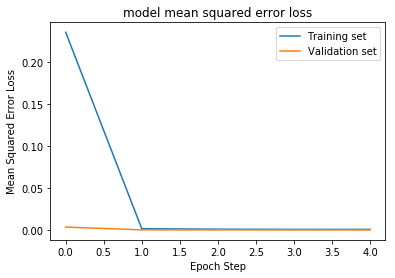

In [15]:
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch Step')
plt.legend(['Training set', 'Validation set'], loc='best')
plt.show()